#  Capital Bikeshare Rental Prediction
---


##  Introduction
---
Bike sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental, and return has become automatic. Through these systems, users can easily rent a bike from a particular position and return it at another.

Currently, there are over 500 bike-sharing programs around the world composed of over 500,000 bicycles. These systems act as a "virtual sensor network" for sensing mobility in the city, explicitly recording travel duration, departure, and arrival positions.

##   Problem Statement
---
**Objective:** The goal of this project is to predict the **total number of rental bikes** (`cnt`) based on environmental and seasonal settings.

* **Problem Type:** Supervised Learning (Regression)
* **Target Variable:** Total rental count
* **Performance Measure:** Root Mean Squared Error (RMSE)

##  Data Source
---
The core dataset is related to a two-year historical log (2011–2012) from the **Capital Bikeshare system** (Washington D.C., USA). The data was aggregated on an hourly and daily basis and enriched with weather information.

* **Original Source:** [Capital Bikeshare System Data](http://capitalbikeshare.com/system-data)
* **Weather Data:** [FreeMeteo](http://www.freemeteo.com)

##  Feature Description
---
The dataset contains the following features used to predict the target variable:

### Environmental & Weather Features
* **`temp`**: Normalized temperature in Celsius.
* **`weathersit`**: Weather situation (Categorical):
    * 1: Clear, Few clouds, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* **`hum`**: Normalized humidity.
* **`windspeed`**: Normalized wind speed.

### Temporal & Categorical Features
* **`season`**: Season (1: winter, 2: spring, 3: summer, 4: fall).
* **`month`**: Month of the year (1 to 12).
* **`hr`**: Hour of the day (0 to 23).
* **`holiday`**: Whether the day is a holiday or not.
* **`weekday`**: Day of the week.



# 🎯  Objective
---
The goal of this project is to predict the number of hourly bike rentals (`cnt`) based on environmental and seasonal features.

# 🛠️ Libraries & Setup
---
Importing necessary tools for data manipulation, visualization, and modeling.

In [ ]:
# --- Data Manipulation ---
import pandas as pd
import numpy as np

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Utilities ---
from ipywidgets import fixed, interact
import warnings
warnings.filterwarnings('ignore')

# --- Machine Learning (Sklearn) ---
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from sklearn.metrics import mean_squared_error

# --- Settings ---
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")



# 📂 Data Loading
---
Loading the dataset and performing an initial check on structure.


In [ ]:
raw = pd.read_csv('datasets/hour.csv')

In [8]:
bike  = raw.drop(['instant', 'dteday', 'yr', 'workingday', 'atemp', 'casual',
       'registered'],axis =1)

In [9]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   mnth        17379 non-null  int64  
 2   hr          17379 non-null  int64  
 3   holiday     17379 non-null  int64  
 4   weekday     17379 non-null  int64  
 5   weathersit  17379 non-null  int64  
 6   temp        17379 non-null  float64
 7   hum         17379 non-null  float64
 8   windspeed   17379 non-null  float64
 9   cnt         17379 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 1.3 MB


In [10]:
X = bike.drop(['cnt'],axis =1)
y = bike['cnt']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state= 42)

# 📊 Exploratory Data Analysis (EDA)
---

In [17]:
training_data = pd.concat([X_train, y_train], axis=1)

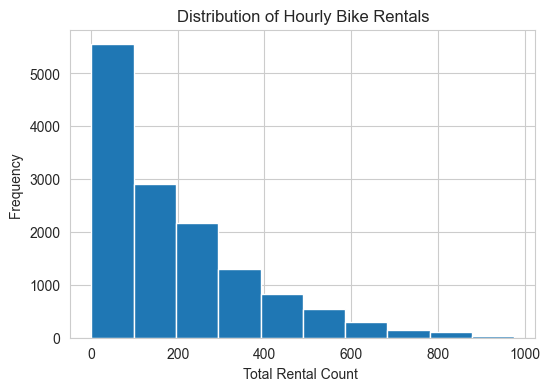

In [ ]:
y_train.hist( figsize=(6, 4))
plt.xlabel('Total Rental Count ')
plt.ylabel('Frequency ')
plt.title('Distribution of Hourly Bike Rentals')
plt.show()

The variable is right skewed, so we might have to treat our target variable.

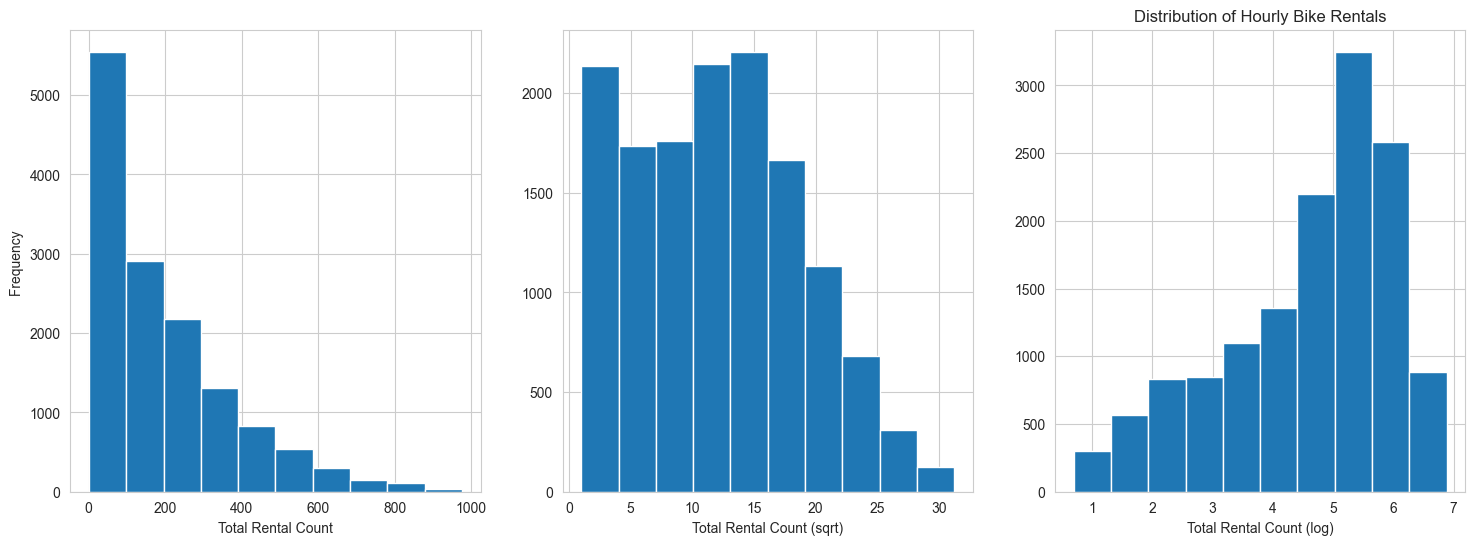

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18, 6))
ax[0].hist(y_train)
ax[1].hist(y_train.apply(np.sqrt))
ax[2].hist(y_train.apply(np.log1p))
ax[0].set_xlabel('Total Rental Count')
ax[1].set_xlabel('Total Rental Count (sqrt)')
ax[2].set_xlabel('Total Rental Count (log)')
ax[0].set_ylabel('Frequency ')
plt.title('Distribution of Hourly Bike Rentals')
plt.show()

Maybe use log as our target variable will be more usefull.

In [12]:
training_data['log_cnt'] = training_data['cnt'].apply(np.log1p)

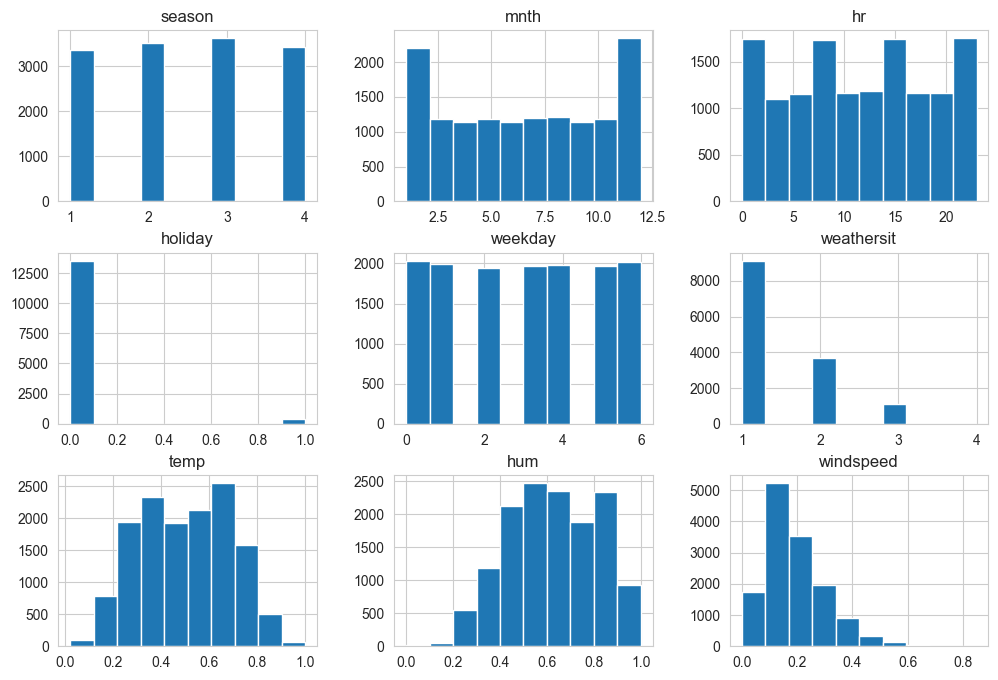

In [ ]:
X_train.hist( figsize=(12, 8))
plt.show()

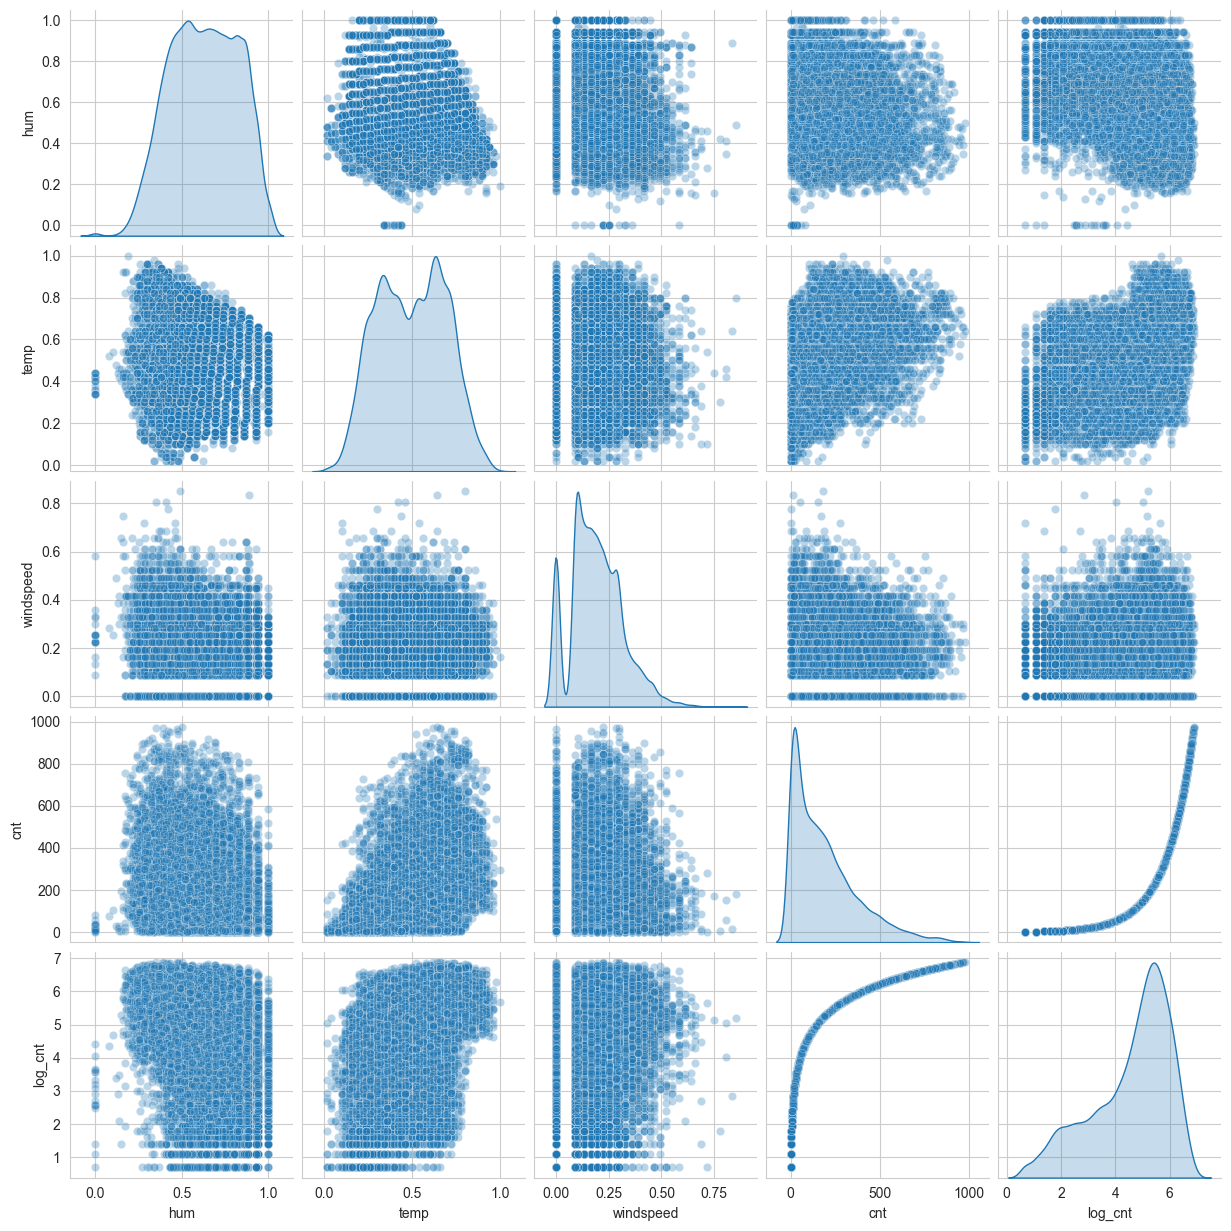

In [ ]:
sns.pairplot(training_data[['hum','temp','windspeed','cnt','log_cnt']],diag_kind='kde', plot_kws={'alpha':0.3})
plt.show()

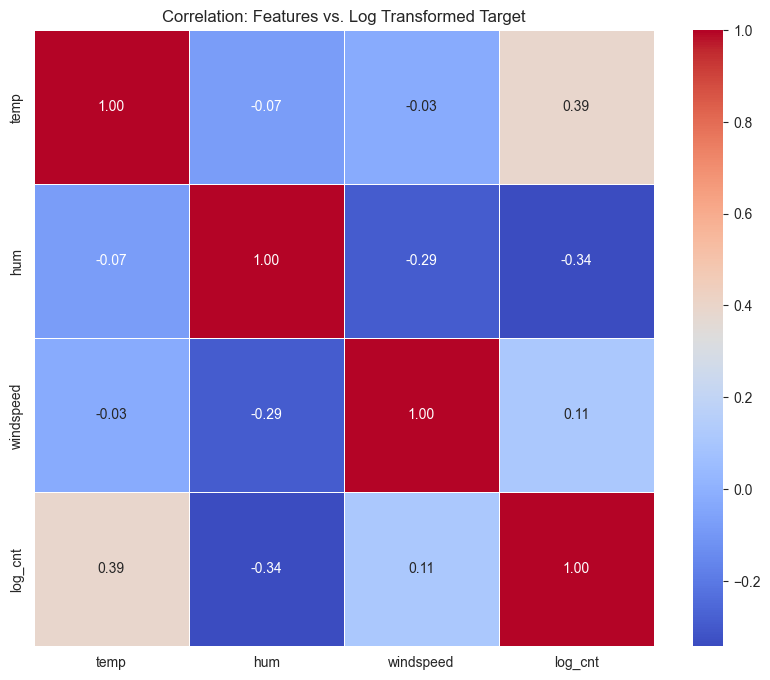

In [ ]:
corr_cols = ['temp', 'hum', 'windspeed', 'log_cnt']
corr_matrix = training_data[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation: Features vs. Log Transformed Target')
plt.show()

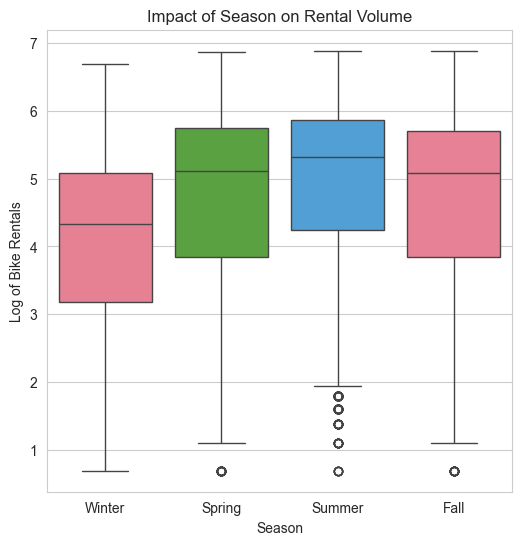

In [ ]:
season_label = ['Winter','Spring','Summer','Fall']
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='season', y='log_cnt',hue='season',legend= False, palette= 'husl', data=training_data)
ax.set_xticklabels(season_label)
ax.set_ylabel("Log of Bike Rentals")
ax.set_xlabel("Season")
plt.title('Impact of Season on Rental Volume')
plt.show()

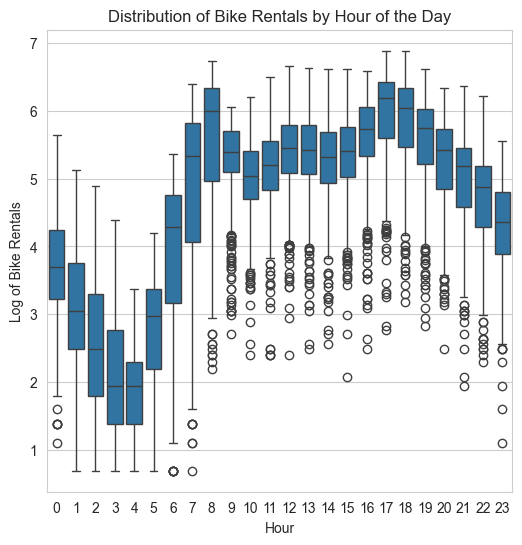

In [ ]:
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='hr', y='log_cnt', data=training_data)
ax.set_ylabel("Log of Bike Rentals")
ax.set_xlabel("Hour")
plt.title('Distribution of Bike Rentals by Hour of the Day')
plt.show()

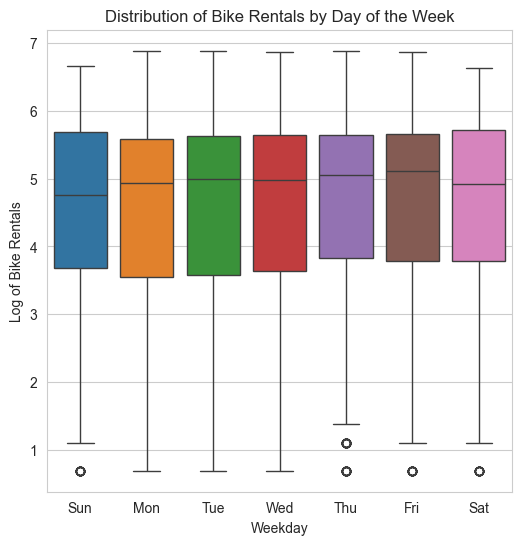

In [ ]:
weekday_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
plt.figure(figsize=(6, 6))
ax = sns.boxplot(x='weekday', y='log_cnt',hue = 'weekday',palette='tab10',legend=False, data=training_data)
ax.set_xticklabels(weekday_labels)
ax.set_ylabel("Log of Bike Rentals")
ax.set_xlabel("Weekday")
plt.title('Distribution of Bike Rentals by Day of the Week')
plt.show()

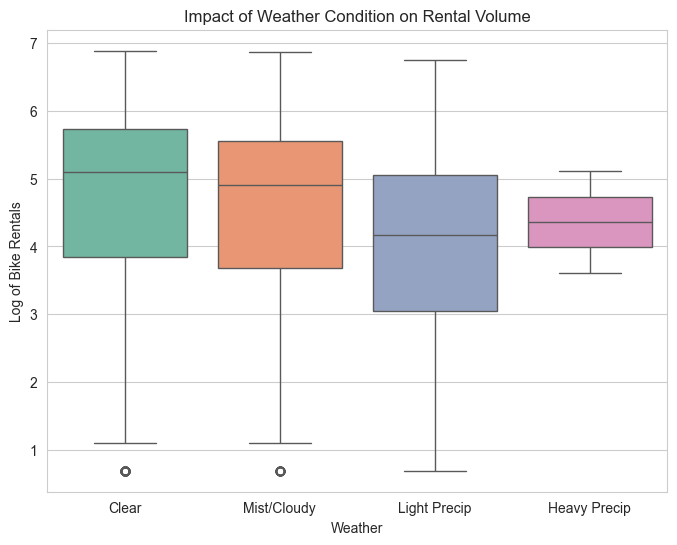

In [ ]:
weather_labels = ['Clear', 'Mist/Cloudy', 'Light Precip', 'Heavy Precip']

plt.figure(figsize=(8, 6))

ax = sns.boxplot(
    x='weathersit',
    y='log_cnt',
    data=training_data,
    palette="Set2",
    hue='weathersit',
    legend=False
)
ax.set_xticklabels(weather_labels)
ax.set_ylabel("Log of Bike Rentals")
ax.set_xlabel("Weather")
plt.title('Impact of Weather Condition on Rental Volume')
plt.show()

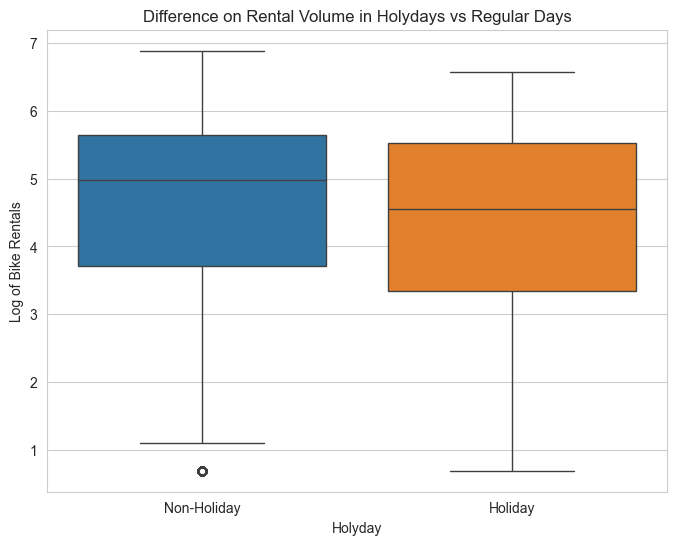

In [ ]:
holiday_labels = ['Non-Holiday', 'Holiday']

plt.figure(figsize=(8, 6))

ax = sns.boxplot(
    x='holiday',
    y='log_cnt',
    data=training_data,
    palette="tab10",
    hue='holiday',
    legend=False
)
ax.set_xticklabels(holiday_labels)
ax.set_ylabel("Log of Bike Rentals")
ax.set_xlabel("Holyday")
plt.title('Difference on Rental Volume in Holydays vs Regular Days')
plt.show()

# ⚙️  Data Preprocessing
---
Preparing data for Machine Learning algorithms.


The `hr` (hour) feature is cyclical (0 to 23). A standard numerical representation implies that 23:00 is far from 00:00 (distance of 23), whereas in reality, they are adjacent.

To fix this, we transform the time into coordinates on a circle using Sine and Cosine functions:
$$x_{sin} = \sin(\frac{2 \pi \times hr}{24})$$
$$x_{cos} = \cos(\frac{2 \pi \times hr}{24})$$

In [14]:
def transform_hour_cyclical(X):
    """
    Transforms a column of hours (0-23) into cyclical features using trigonometric functions.

    This function maps hours onto a 24-hour circle to preserve the temporal
    proximity between 23:00 and 00:00.

    Parameters
    ----------
    X : array-like, shape (n_samples, 1) or (n_samples,)
        Input array containing the hour data (integers from 0 to 23).
        Can be a Pandas Series, DataFrame column, or NumPy array.

    Returns
    -------
    X_out : np.ndarray, shape (n_samples, 2)
        Concatenated array containing the two new transformed features:
        - Column 0: Sine component of the hour.
        - Column 1: Cosine component of the hour.
    """
    X = np.array(X, dtype=float)
    X_sin = np.sin((2 * np.pi * X) / 24)
    X_cos = np.cos((2 * np.pi * X) / 24)
    X_out = np.c_[X_sin,X_cos]
    return X_out

We use a `ColumnTransformer` to apply specific treatments to different data types to prevent data leakage:
* **Numerical features:** Standard Scaling (`StandardScaler`).
* **Categorical features:** One-Hot Encoding (`OneHotEncoder`).
* **Cyclical features:** Custom Function Transformer (Sine/Cosine).

In [ ]:


num_attribs = ["temp","hum","windspeed"]
cat_attribs = ["season", "mnth","holiday","weekday","weathersit"]
cyc_attribs = ['hr']

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
StandardScaler())

cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown="ignore"))

hour_transformer = FunctionTransformer(transform_hour_cyclical, validate=False)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
    ("cyc", hour_transformer, cyc_attribs)
])

In [25]:
print(f"shape before preprocessing: {X_train.shape}")
X_train_prepared = preprocessing.fit_transform(X_train)
y_train = y_train.apply(np.log1p)
print(f"shape after preprocessing: {X_train_prepared.shape}")

shape before preprocessing: (13903, 9)
shape after preprocessing: (13903, 34)


# 🧠  Model Selection & Training
---
Training models and searching for optimal hyperparameters.

> ###  Model Comparison

In [21]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "KNN Regressor": KNeighborsRegressor(),
    "XGBoost": XGBRegressor(random_state=42)
}
results = {}

for name, model in models.items():
    full_pipeline = make_pipeline(preprocessing, model)
    scores = cross_val_score(full_pipeline,
                             X_train,
                             y_train,
                             scoring="neg_root_mean_squared_error",
                             cv=5,
                             n_jobs = -1
                             )

    rmse_scores = -scores

    results[name] = {"mean": rmse_scores.mean(), "std": rmse_scores.std()}

    print("=" * 30)
    print(f"Model: {name}")
    print(f"  RMSE mean: {rmse_scores.mean():.4f}")
    print(f"  Standard deviation: {rmse_scores.std():.4f}")
    print("=" * 30)

best_model = min(results, key=lambda k: results[k]['mean'])
print("-" * 30)
print(f"Best Model: {best_model}\n Best RMSE {results[best_model]['mean']:.4f}")
print("-" * 30)

Comparing the Models using Cross Validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Model: Linear Regression
  RMSE mean: 0.8966
  Standard deviation: 0.0053


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Model: Random Forest
  RMSE mean: 0.3961
  Standard deviation: 0.0044


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Model: KNN Regressor
  RMSE mean: 0.7449
  Standard deviation: 0.0154
Model: XGBoost
  RMSE mean: 0.3661
  Standard deviation: 0.0047
------------------------------

 Best Model: XGBoost
 Best RMSE 0.3661
------------------------------


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [26]:

rf_pipeline = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))


rf_param_dist = {
    'randomforestregressor__n_estimators': randint(low=100, high=500),
    'randomforestregressor__max_depth': [None, 10, 20, 30],
    'randomforestregressor__min_samples_leaf': randint(low=1, high=10),
    'randomforestregressor__max_features': [1.0, 'sqrt', 'log2']
}


rf_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("=" * 30)
print(f"Best RMSE: {-rf_search.best_score_:.4f}")
print(f"Best Params: {rf_search.best_params_}")
print("=" * 30)


Best RMSE: 0.4006
Best Params: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 1.0, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 413}


In [27]:
xgb_pipeline = make_pipeline(preprocessing, XGBRegressor(random_state=42))

xgb_param_dist = {
    'xgbregressor__n_estimators': randint(low=100, high=1000),
    'xgbregressor__learning_rate': uniform(0.01, 0.2),
    'xgbregressor__max_depth': randint(low=3, high=10),
    'xgbregressor__subsample': uniform(0.6, 0.4),
    'xgbregressor__colsample_bytree': uniform(0.6, 0.4)
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_root_mean_squared_error'
)

xgb_search.fit(X_train, y_train)

print("=" * 30)
print(f"Best  RMSE: {-xgb_search.best_score_:.4f}")
print(f"Best Params: {xgb_search.best_params_}")
print("=" * 30)

Best  RMSE: 0.3577
Best Params: {'xgbregressor__colsample_bytree': np.float64(0.9180770312616426), 'xgbregressor__learning_rate': np.float64(0.04899724147906756), 'xgbregressor__max_depth': 6, 'xgbregressor__n_estimators': 551, 'xgbregressor__subsample': np.float64(0.7816824819758744)}


Based on the initial comparison, **XGBoost** showed the best performance (lowest RMSE). We now perform a **Grid Search** to fine-tune the hyperparameters, specifically focusing on:
* `n_estimators` (Number of trees)
* `max_depth` (Tree complexity)
* `learning_rate` (Step size shrinkage)


> ### Fine-tuning

In [31]:

param_grid_fine = {
    'xgbregressor__n_estimators': [500, 550, 600],

    'xgbregressor__max_depth': [5, 6, 7],

    'xgbregressor__learning_rate': [0.04, 0.05, 0.06],

    'xgbregressor__colsample_bytree': [0.92],
    'xgbregressor__subsample': [0.78]
}

grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_fine,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose = 3,
    n_jobs = -1
)

grid_search.fit(X_train, y_train)

print("=" * 30)
print(f"Best RMSE : {-grid_search.best_score_:.4f}")
print("Best Params:", grid_search.best_params_)
print("=" * 30)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best RMSE : 0.3560
Best Params: {'xgbregressor__colsample_bytree': 0.92, 'xgbregressor__learning_rate': 0.05, 'xgbregressor__max_depth': 7, 'xgbregressor__n_estimators': 600, 'xgbregressor__subsample': 0.78}


# 📉  Model Evaluation
---
Finally, we evaluate the tuned model on the **Test Set** (unseen data).
We also visualize the residuals to check for any systematic errors in predictions.

In [34]:
y_test = y_test.apply(np.log1p)

In [36]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("-" * 30)
print(f"RMSE in the test group: {final_rmse:.4f}")
print("-" * 30)

------------------------------
RMSE in the test group: 0.3390
------------------------------


In [39]:


final_predictions_normal_scale = np.expm1(final_predictions)
y_test_normal_scale = np.expm1(y_test)


rmse_real = np.sqrt(mean_squared_error(y_test_normal_scale, final_predictions_normal_scale))
print("=" * 30)
print(f"RMSE in log scale:  {final_rmse:.4f}")
print("-" * 30)
print(f"RMSE in bike scale: {rmse_real:.2f}")
print("=" * 30)

RMSE in log scale:  0.3390
------------------------------
RMSE in bike scale: 58.78


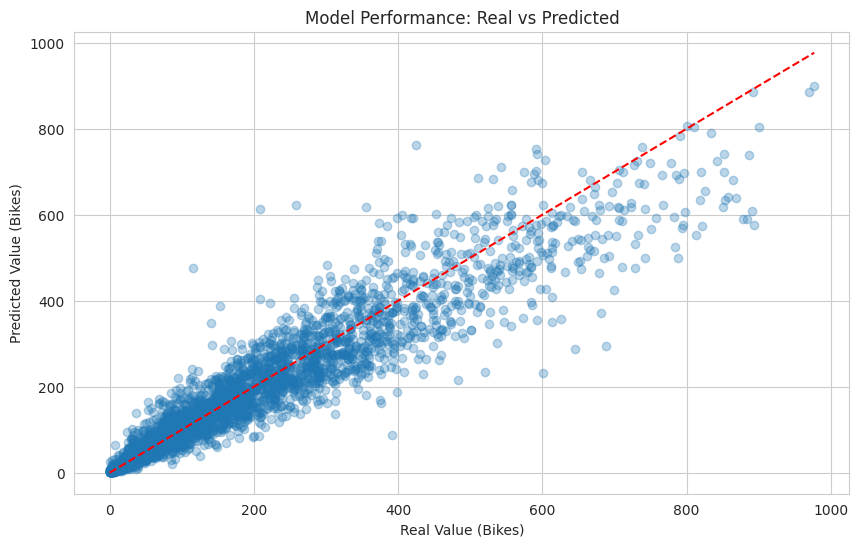

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_normal_scale, final_predictions_normal_scale, alpha=0.3)
plt.plot([0, max(y_test_normal_scale)], [0, max(y_test_normal_scale)], color='red', linestyle='--')
plt.xlabel('Real Value (Bikes)')
plt.ylabel('Predicted Value (Bikes)')
plt.title('Model Performance: Real vs Predicted')
plt.show()

# 🔍  Conclusion
---

The model's performance on the test set was even better than on the training set. This shows that it learned the demand patterns and did not overfit the data. However, as we can see, the model performs worse as the target value increases. This is because the dataset is right-skewed, so we have fewer observations for this kind of case.